## Creating the dataset

### Load libraries

In [1]:
import os
import sys

src_path = os.path.abspath("../")
sys.path.append(src_path)

from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.io.stata import StataReader

from utils.retirement import *

# from scipy.linalg import eigh

### Load and merge all needed datasets for Sharelife

In [2]:
folder = "/Users/alexandralugova/Documents/GitHub/MH-old-workers/data/datasets/sharew7_rel8-0-0_ALL_datasets_stata/"
merge_columns = ["mergeid", "hhid7", "mergeidp7", "coupleid7", "country", "language"]
datasets = []

for filename in os.listdir(folder):
    if (
        filename.endswith("cv_r.dta")
        or filename.endswith("technical_variables.dta")
        or filename.endswith("dn.dta")
        # or filename.endswith("ra.dta")
        # or filename.endswith("cc.dta")
        # or filename.endswith("dq.dta")
        or filename.endswith("fs.dta")
        # or filename.endswith("gl.dta")
        or filename.endswith("rh.dta")
        or filename.endswith("hs.dta")
        or filename.endswith("rc.dta")
        or filename.endswith("re.dta")
        or filename.endswith("rp.dta")
        or filename.endswith("wq.dta")
        or filename.endswith("gv_weights.dta")
    ):
        file_path = os.path.join(folder, filename)
        dataset = pd.read_stata(file_path, convert_categoricals=False)
        datasets.append(dataset)

df = reduce(lambda left, right: pd.merge(left, right, on=merge_columns), datasets)

In [3]:
# Leave only Sharelife part
df = df[df.mn103_ == 1].reset_index(drop=True)

In [4]:
# Unique individuals
df.mergeid.nunique()

63248

### Transform some variables, filter data and choose only necessary columns

Transform countries from codes to names

In [5]:
with StataReader(
    "/Users/alexandralugova/Documents/GitHub/MH-old-workers/data/datasets/sharew7_rel8-0-0_ALL_datasets_stata/sharew7_rel8-0-0_cv_r.dta",
    convert_categoricals=True,
) as reader:
    data = reader.read()
    value_labels = reader.value_labels()
df["country"] = df["country"].replace(value_labels.get("country"))

df["country"].value_counts(dropna=False)

country
Estonia           5115
Slovenia          3691
Poland            3559
Spain             3424
Belgium           3333
Czech Republic    3292
Italy             3000
Germany           2984
Austria           2693
Croatia           2408
France            2188
Israel            2131
Sweden            2130
Romania           2114
Slovakia          2077
Lithuania         2035
Finland           2007
Bulgaria          1998
Denmark           1962
Latvia            1734
Switzerland       1648
Hungary           1538
Portugal          1282
Malta             1261
Luxembourg        1250
Cyprus            1233
Greece            1161
Name: count, dtype: int64

Transform gender to 1=female, 0=male

In [6]:
df["gender"] = df["gender"].replace({1: 0, 2: 1})

df["gender"].value_counts(dropna=False)

gender
1    36040
0    27208
Name: count, dtype: int64

Filter for aged 50+ as for 2011 (56+ in 2017)

In [7]:
df = df[df.age2017 >= 56].reset_index(drop=True)

Format variable indicating first year in the country

In [8]:
# Rename and fill missing values with year of birth
df["dn006_"] = df["dn006_"].fillna(df["yrbirth"])
df = df.rename(columns={"dn006_": "yr1country"})

# Drop individuals with missing answers
df = df[df.yr1country > 0].reset_index(drop=True)

df["yr1country"].describe()

count    56477.000000
mean      1947.955079
std          9.507598
min       1912.000000
25%       1941.000000
50%       1949.000000
75%       1955.000000
max       2017.000000
Name: yr1country, dtype: float64

Identify the number of education years

In [9]:
waves = [1, 2, 4, 5, 6, 7]
dfs = []

for wave in waves:
    file_path = f"/Users/alexandralugova/Documents/GitHub/MH-old-workers/data/datasets/sharew{wave}_rel8-0-0_ALL_datasets_stata/sharew{wave}_rel8-0-0_dn.dta"
    data = pd.read_stata(file_path, convert_categoricals=False)
    dfs.append(data)

dn_data = pd.concat(dfs, ignore_index=True)

edu_sum = dn_data.groupby("mergeid").dn041_.sum().to_frame().reset_index()
edu_sum = edu_sum[(edu_sum.dn041_ >= 0) & (edu_sum.dn041_ <= 40)].reset_index(drop=True)
edu_sum = edu_sum.rename(columns={"dn041_": "yrseducation"})

df = df.merge(edu_sum, on="mergeid", how="left")

# Drop individuals with missing values
df = df.dropna(subset="yrseducation").reset_index(drop=True)

df.yrseducation.describe()

count    55496.000000
mean        10.876532
std          4.453837
min          0.000000
25%          8.000000
50%         11.000000
75%         13.000000
max         40.000000
Name: yrseducation, dtype: float64

Identify current job isco

In [10]:
isco_columns = [f"re012isco_{i}" for i in range(1, 21)]


def get_last_valid(row):
    last_valid_index = row.last_valid_index()
    if pd.notnull(last_valid_index):
        return row[last_valid_index]
    else:
        return pd.NA


df["isco"] = df[isco_columns].apply(get_last_valid, axis=1)

# Drop individuals with missing values
df = df[df.isco > 0].reset_index(drop=True)
df = df.dropna(subset="isco").reset_index(drop=True)

# Correct some of the codes that are wrong due to formatting - one 0 is missing at the end
df["isco"] = df["isco"].astype(int)
df["isco"] = df["isco"].apply(lambda x: x * 10 if 99 < x < 1000 else x)

# Drop codes with less than 10 individuals
# isco_filter = df["isco"].value_counts().to_frame().reset_index()
# selected_isco = isco_filter[isco_filter["count"] >= 10]["isco"].tolist()
# df = df[df["isco"].isin(selected_isco)].reset_index(drop=True)

df["isco"].value_counts()

isco
4110    1305
5223    1086
9112     747
2221     677
2341     622
        ... 
2358       1
2357       1
2122       1
7544       1
3514       1
Name: count, Length: 444, dtype: int64

Leave only individuals that did not change job between 2011 and 2017

In [11]:
start_columns = [f"re011_{i}" for i in range(1, 21)]
df["job_start"] = df[start_columns].apply(get_last_valid, axis=1)
df = df[df["job_start"] <= 2011].reset_index(drop=True)

Calculate contribution years and first year of contribution

In [12]:
# Load job episodes panel data (from retrospective waves 3 and 7)
jobs = pd.read_stata(
    "/Users/alexandralugova/Documents/GitHub/MH-old-workers/data/datasets/sharewX_rel8-0-0_gv_job_episodes_panel.dta"
)

# Calculate number of years of work for each individual
conditions = ["Employee or self-employed", "Short term job (less than 6 months)"]
relevant_rows = jobs[jobs["situation"].isin(conditions)]

max_year = relevant_rows.groupby("mergeid")["year"].max().to_frame().reset_index()
result_jobs = (
    relevant_rows.groupby("mergeid").size().reset_index(name="yrscontribution2017")
)
max_year = max_year.merge(result_jobs, on="mergeid", how="left")
max_year[["yrscontribution2017", "year"]] = max_year[
    ["yrscontribution2017", "year"]
].astype("int")
max_year["yrscontribution2017"] += (2017 - max_year["year"]).where(
    max_year["year"] < 2017, 0
)
max_year["yrscontribution2017"] -= (max_year["year"] - 2017).where(
    max_year["year"] > 2017, 0
)

# Calculate the year of first contribution
first_contribution = (
    relevant_rows.groupby("mergeid")["year"].min().reset_index(name="yr1contribution")
)

# Merge with main dataset
df = df.merge(max_year[["mergeid", "yrscontribution2017"]], on="mergeid", how="left")
df = df.merge(first_contribution, on="mergeid", how="left")

# Delete those with less than 10 years of contributions in 2017
df = df[df["yrscontribution2017"] >= 10].reset_index(drop=True)

# Delete those who started work before the age of 10
df["yr1contribution"] = df["yr1contribution"].astype("int")
df = df[df["yr1contribution"] >= df["yrbirth"].astype(int) + 10]

In [13]:
# Individuals left after filters
len(df)

39820

Choose only necessary columns

In [14]:
df = df[
    [
        "mergeid",
        "country",
        "gender",
        "yrbirth",
        "mobirth",
        "age2017",
        "yr1country",
        "yrseducation",
        "isco",
        "yrscontribution2017",
        "yr1contribution",
    ]
]

In [15]:
# Last formatting
df["mobirth"] = df["mobirth"].fillna(1)

### Add additional data for individuals with isco codes from waves 6, 7 and 8

Load datasets for waves 6,7 and 8

In [16]:
datasets = []

folders = [
    f"/Users/alexandralugova/Documents/GitHub/MH-old-workers/data/datasets/sharew{i}_rel8-0-0_ALL_datasets_stata"
    for i in [6, 7, 8]
]

merge_columns = ["mergeid"]

for folder in folders:
    wave = int(folder.split("sharew")[1].split("_")[0])

    folder_datasets = []

    for filename in os.listdir(folder):
        if (
            filename.endswith("cv_r.dta")
            or filename.endswith("dn.dta")
            or filename.endswith("ch.dta")
            or filename.endswith("ep.dta")
        ):
            file_path = os.path.join(folder, filename)
            dataset = pd.read_stata(file_path)

            dataset["wave"] = wave

            folder_datasets.append(dataset)

    if folder_datasets:
        merged_dataset = reduce(
            lambda left, right: pd.merge(
                left,
                right,
                on=left.columns.intersection(right.columns).tolist(),
                how="inner",
            ),
            folder_datasets,
        )

        datasets.append(merged_dataset)

waves = pd.concat(datasets, sort=False, axis=0).reset_index(drop=True)

/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykernel_62536/1098949800.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  waves = pd.concat(datasets, sort=False, axis=0).reset_index(drop=True)
/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykernel_62536/1098949800.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  waves = pd.concat(datasets, sort=False, axis=0).reset_index(drop=True)
/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykernel_62536/1098949800.py:42: FutureWarning: Th

Leave only individuals with isco codes that are not already present in Sharelife (wave 7)

In [17]:
waves = waves.dropna(subset="ep616isco").reset_index(drop=True)
waves = waves[
    (waves.ep616isco != "Don't know") & (waves.ep616isco != "Not yet coded")
].reset_index(drop=True)
waves = waves[~waves["mergeid"].isin(df["mergeid"])].reset_index(drop=True)

Leave only the first wave with isco code for each individual

In [18]:
waves = waves.loc[waves.groupby("mergeid")["wave"].idxmin()].reset_index(drop=True)

Transform gender to 1=female, 0=male

In [19]:
waves["gender"] = waves["gender"].replace({"Male": 0, "Female": 1})

waves["gender"].value_counts(dropna=False)

gender
1    3849
0    3032
Name: count, dtype: int64

Filter for aged 50+ as for 2011 (54+ in 2015, 56+ in 2017, 59+ in 2020)

In [20]:
waves = waves[
    (waves.age2015 >= 54) | (waves.age2017 >= 56) | (waves.age2020 >= 59)
].reset_index(drop=True)

Format variable indicating first year in the country

In [21]:
# Rename and fill missing values with year of birth
waves["dn006_"] = waves["dn006_"].fillna(waves["yrbirth"])
waves = waves.rename(columns={"dn006_": "yr1country"})

# Drop individuals with missing answers
waves = (
    waves[(waves.yr1country != "Refusal") & (waves.yr1country != "Don't know")]
    .dropna(subset="yr1country")
    .reset_index(drop=True)
)
waves["yr1country"] = waves["yr1country"].astype("int")

waves["yr1country"].describe()

count    3649.000000
mean     1956.093176
std         8.174199
min      1926.000000
25%      1953.000000
50%      1956.000000
75%      1959.000000
max      2016.000000
Name: yr1country, dtype: float64

Identify the number of education years

In [22]:
ws = [1, 2, 4, 5, 6, 7]
dfs = []

for wave in ws:
    file_path = f"/Users/alexandralugova/Documents/GitHub/MH-old-workers/data/datasets/sharew{wave}_rel8-0-0_ALL_datasets_stata/sharew{wave}_rel8-0-0_dn.dta"
    data = pd.read_stata(file_path, convert_categoricals=False)
    dfs.append(data)

dn_data = pd.concat(dfs, ignore_index=True)

edu_sum = dn_data.groupby("mergeid").dn041_.sum().to_frame().reset_index()
edu_sum = edu_sum[(edu_sum.dn041_ >= 0) & (edu_sum.dn041_ <= 40)].reset_index(drop=True)
edu_sum = edu_sum.rename(columns={"dn041_": "yrseducation"})

waves = waves.merge(edu_sum, on="mergeid", how="left")

# Drop individuals with missing values
waves = waves.dropna(subset="yrseducation").reset_index(drop=True)

waves.yrseducation.describe()

count    3445.000000
mean       12.576197
std         4.666669
min         0.000000
25%        10.000000
50%        12.000000
75%        16.000000
max        38.000000
Name: yrseducation, dtype: float64

Identify current job isco

In [23]:
waves = waves.rename(columns={"ep616isco": "isco"})
waves["isco"] = waves["isco"].astype(int)

# Drop codes with less than 10 individuals
# isco_filter = waves["isco"].value_counts().to_frame().reset_index()
# selected_isco = isco_filter[isco_filter["count"] >= 10]["isco"].tolist()
# waves = waves[waves["isco"].isin(selected_isco)].reset_index(drop=True)

waves["isco"].value_counts()

isco
9999    120
9112     90
4110     68
2221     66
9111     53
       ... 
8159      1
8121      1
6123      1
1344      1
9331      1
Name: count, Length: 375, dtype: int64

Leave only individuals that did not change job between 2011 and 2015

In [24]:
ws = [5, 6]
dfs = []

for wave in ws:
    file_path = f"/Users/alexandralugova/Documents/GitHub/MH-old-workers/data/datasets/sharew{wave}_rel8-0-0_ALL_datasets_stata/sharew{wave}_rel8-0-0_ep.dta"
    data = pd.read_stata(file_path, convert_categoricals=False)
    dfs.append(data)

ep_data = pd.concat(dfs, ignore_index=True)
ep_data = ep_data[ep_data["mergeid"].isin(waves["mergeid"])].reset_index(drop=True)
ep_data = ep_data[
    (ep_data.ep141d1 != "Selected")
    & (ep_data.ep141d2 != "Selected")
    & (ep_data.ep141d3 != "Selected")
].reset_index(drop=True)

waves = waves[waves["mergeid"].isin(ep_data["mergeid"])].reset_index(drop=True)

Calculate contribution years and first year of contribution

In [25]:
# Merge with job panel data
waves = waves.merge(
    max_year[["mergeid", "yrscontribution2017"]], on="mergeid", how="left"
)
waves = waves.merge(first_contribution, on="mergeid", how="left")

# Delete those with less than 10 years of contributions in 2017
waves = waves[waves["yrscontribution2017"] >= 10].reset_index(drop=True)

# Delete those who started work before the age of 10
waves = waves[waves["yr1contribution"].astype(int) >= waves["yrbirth"].astype(int) + 10]

In [26]:
len(waves)

1629

Choose only necessary columns

In [27]:
waves = waves[
    [
        "mergeid",
        "country",
        "gender",
        "yrbirth",
        "mobirth",
        "age2015",
        "age2017",
        "age2020",
        "yr1country",
        "yrseducation",
        "isco",
        "yrscontribution2017",
        "yr1contribution",
    ]
]

In [28]:
# Last formatting - Transform month to numeric
month_to_numeric = {
    "January": 1,
    "February": 2,
    "March": 3,
    "April": 4,
    "May": 5,
    "June": 6,
    "July": 7,
    "August": 8,
    "September": 9,
    "October": 10,
    "November": 11,
    "December": 12,
}

waves["mobirth"] = waves["mobirth"].map(month_to_numeric)

Concat additional data to the main dataframe

In [29]:
df = pd.concat([df, waves], axis=0).reset_index(drop=True)

### Load and merge all needed datasets for SHARE Waves 4 and 6

In [30]:
datasets = []

folders = [
    f"/Users/alexandralugova/Documents/GitHub/MH-old-workers/data/datasets/sharew{i}_rel8-0-0_ALL_datasets_stata"
    for i in [4, 5, 6]
]

merge_columns = ["mergeid"]

for folder in folders:
    wave = int(folder.split("sharew")[1].split("_")[0])

    folder_datasets = []

    for filename in os.listdir(folder):
        if (
            filename.endswith("cv_r.dta")
            or filename.endswith("ch.dta")
            or filename.endswith("ep.dta")
            or filename.endswith("gv_health.dta")
        ):
            file_path = os.path.join(folder, filename)
            dataset = pd.read_stata(file_path)

            dataset["wave"] = wave

            folder_datasets.append(dataset)

    if folder_datasets:
        merged_dataset = reduce(
            lambda left, right: pd.merge(
                left,
                right,
                on=left.columns.intersection(right.columns).tolist(),
                how="inner",
            ),
            folder_datasets,
        )

        datasets.append(merged_dataset)

w46 = pd.concat(datasets, sort=False, axis=0).reset_index(drop=True)

/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykernel_62536/718305599.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  w46 = pd.concat(datasets, sort=False, axis=0).reset_index(drop=True)
/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykernel_62536/718305599.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  w46 = pd.concat(datasets, sort=False, axis=0).reset_index(drop=True)
/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykernel_62536/718305599.py:42: FutureWarning: The behav

In [31]:
# Unique individuals
w46.groupby("wave").mergeid.nunique()

wave
4    58000
5    66065
6    68085
Name: mergeid, dtype: int64

Check the number of individuals present in waves 4-6 and 7

In [32]:
unique_mergeid_w46 = set(w46["mergeid"].unique())
unique_mergeid_df = set(df["mergeid"].unique())
intersection_ids = unique_mergeid_w46.intersection(unique_mergeid_df)
len(intersection_ids)

32253

Leave only individuals present in at least one of waves 4-6 and in wave 7

In [33]:
w46 = w46[w46["mergeid"].isin(intersection_ids)].reset_index(drop=True)

### Transform some variables, filter data and choose only necessary columns

Add year column

In [34]:
wave_to_year = {4: 2011, 5: 2013, 6: 2015}
w46["year"] = w46["wave"].map(wave_to_year).astype(int)

Calculate current age

In [35]:
def calculate_age(row):
    if not pd.isnull(row["age2011"]):
        return row["age2011"] + (row["year"] - 2011)
    elif not pd.isnull(row["age2013"]):
        return row["age2013"] - (2013 - row["year"])
    elif not pd.isnull(row["age2015"]):
        return row["age2015"] - (2015 - row["year"])
    else:
        return np.nan


w46["age"] = w46.apply(calculate_age, axis=1)

Identify number of children by year

In [36]:
# Drop those who refused to answer, put 0 for those who don't know
w46 = w46[(w46.ch001_ != "Refusal")].reset_index(drop=True)
w46["ch001_"] = w46["ch001_"].replace({"Don't know": 0})

children2011 = (
    w46[w46.wave == 4]
    .groupby("hhid4")["ch001_"]
    .max()
    .to_frame(name="nb_children2011")
    .reset_index()
    .fillna(0)
)
children2013 = (
    w46[w46.wave == 5]
    .groupby("hhid5")["ch001_"]
    .max()
    .to_frame(name="nb_children2013")
    .reset_index()
    .fillna(0)
)
children2015 = (
    w46[w46.wave == 6]
    .groupby("hhid6")["ch001_"]
    .max()
    .to_frame(name="nb_children2015")
    .reset_index()
    .fillna(0)
)

w46 = w46.merge(children2011, on="hhid4", how="left")
w46 = w46.merge(children2013, on="hhid5", how="left")
w46 = w46.merge(children2015, on="hhid6", how="left")

In [37]:
len(w46) - (
    len(
        w46[
            (w46.nb_children2011 >= 0)
            | (w46.nb_children2013 >= 0)
            | (w46.nb_children2015 >= 0)
        ]
    )
)

0

In [38]:
w46["nb_children"] = (
    w46["nb_children2011"]
    .combine_first(w46["nb_children2013"])
    .combine_first(w46["nb_children2015"])
)
w46["nb_children"].describe()

count    69845.000000
mean         1.927740
std          1.368505
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: nb_children, dtype: float64

In [39]:
# Unique individuals
w46.groupby("wave").mergeid.nunique()

wave
4    16232
5    24483
6    29130
Name: mergeid, dtype: int64

Transform partnerinhh to 1=lives with partner and 0=without

In [40]:
w46["partnerinhh"] = w46["partnerinhh"].replace({"Yes": 1, "No": 0})

w46["partnerinhh"].value_counts(dropna=False)

partnerinhh
1                 51516
0                 18329
Not applicable        0
Name: count, dtype: int64

Leave only those with the status of employed

In [41]:
w46.ep005_.value_counts(dropna=False)

ep005_
Retired                                                              40264
Employed or self-employed (including working for family business)    21064
Homemaker                                                             3229
Permanently sick or disabled                                          2066
Unemployed                                                            2022
Other                                                                  744
NaN                                                                    426
Refusal                                                                 15
Don't know                                                              15
Name: count, dtype: int64

In [42]:
w46 = w46[
    w46.ep005_ == "Employed or self-employed (including working for family business)"
].reset_index(drop=True)

In [43]:
# Unique individuals
w46.groupby("wave").mergeid.nunique()

wave
4    5542
5    7743
6    7779
Name: mergeid, dtype: int64

Delete those who hold state pensions for disabilities or other special conditions

In [44]:
# ep071dno and ep671dno (from wave 6) - no current state pensions
w46 = w46[(w46.ep071dno == "Selected") | (w46.ep671dno == "Selected")].reset_index(
    drop=True
)

In [45]:
# Unique individuals
w46.groupby("wave").mergeid.nunique()

wave
4    4625
5    6495
6    6431
Name: mergeid, dtype: int64

Add job status variable

In [46]:
w46["ep009_"] = (
    w46["ep009_"]
    .replace({"Don't know": "Employee", "Refusal": "Employee"})
    .fillna("Employee")
)
w46 = w46.rename(columns={"ep009_": "job_status"})

### Calculate mental health indicators

Filter out those with missing values for EuroD scale

In [47]:
w46 = w46.dropna(subset=["eurod"]).reset_index(drop=True)

Transform EuroD values to numeric

In [48]:
# Transform to numeric
w46["eurod"] = w46["eurod"].replace({"Not depressed": 0, "Very depressed": 12})
w46["eurodcat"] = w46["eurodcat"].replace({"Yes": 1, "No": 0})
w46[
    [
        "euro1",
        "euro2",
        "euro3",
        "euro4",
        "euro5",
        "euro6",
        "euro7",
        "euro8",
        "euro9",
        "euro10",
        "euro11",
        "euro12",
    ]
] = w46[
    [
        "euro1",
        "euro2",
        "euro3",
        "euro4",
        "euro5",
        "euro6",
        "euro7",
        "euro8",
        "euro9",
        "euro10",
        "euro11",
        "euro12",
    ]
].applymap(
    lambda x: 1 if x == "Selected" else 0
)

/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykernel_62536/483394848.py:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ].applymap(


In [49]:
# Unique individuals
w46.groupby("wave").mergeid.nunique()

wave
4    4547
5    6366
6    6275
Name: mergeid, dtype: int64

### Choose columns and join datasets

In [50]:
w46 = w46[
    [
        "mergeid",
        "wave",
        "year",
        "age",
        "nb_children",
        "partnerinhh",
        "job_status",
        "eurod",
        "eurodcat",
    ]
]

In [51]:
df = w46.merge(df, on=["mergeid"], how="left")

Some missing transformations

In [52]:
# Drop extra age columns
df = df.drop(columns=["age2015", "age2017", "age2020"])

# Recalculate years of contribution


def calculate_contribution(row):
    if row["year"] == 2011:
        return row["yrscontribution2017"] - 6
    elif row["year"] == 2013:
        return row["yrscontribution2017"] - 4
    else:
        return row["yrscontribution2017"] - 2


df["yrscontribution"] = df.apply(calculate_contribution, axis=1)
df = df.drop(columns="yrscontribution2017")

# Change some data types
columns_to_convert = ["partnerinhh", "eurod", "eurodcat", "yrbirth"]
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors="coerce")
df.dropna(subset=columns_to_convert, inplace=True)

### Set legal retirement ages

In [53]:
country_functions_age = {
    "Austria": austria_age,
    "Belgium": belgium_age,
    "Czech Republic": czech_republic_age,
    "Denmark": denmark_age,
    "Estonia": estonia_age,
    "France": france_age,
    "Germany": germany_age,
    "Italy": italy_age,
    # "Luxembourg": luxembourg_age,
    # "Netherlands": netherlands_age,
    # "Poland": poland_age,
    "Slovenia": slovenia_age,
    "Spain": spain_age,
    "Switzerland": switzerland_age,
}


def calculate_retirement_age(row):
    country = row["country"]
    if country in country_functions_age:
        return country_functions_age[country](row)
    else:
        return None

In [54]:
# Apply country-wise functions to calculate legal retirement age
df["retirement_age"] = df.apply(calculate_retirement_age, axis=1)

# Delete those who are above the retirement age (continue to work longer)
df = df[df["retirement_age"] > df["age"]].reset_index(drop=True)

In [55]:
# Unique individuals
df.groupby("wave").mergeid.nunique()

wave
4    3654
5    4960
6    4452
Name: mergeid, dtype: int64

### Calculate resting work horizon and its change due to reforms

In [56]:
# Calculate resting work horizon
df["work_horizon"] = df["retirement_age"] - df["age"]

In [57]:
df.country.unique()

array(['Austria', 'Belgium', 'Czech Republic', 'Switzerland', 'Germany',
       'Denmark', 'Estonia', 'Spain', 'France', 'Italy', 'Slovenia'],
      dtype=object)

In [58]:
country_functions_change = {
    "Austria": austria_change,
    "Belgium": belgium_change,
    "Czech Republic": czech_republic_change,
    "Denmark": denmark_change,
    "Estonia": estonia_change,
    "France": france_change,
    "Germany": germany_change,
    "Italy": italy_change,
    # "Luxembourg": luxembourg_change,
    # "Netherlands": netherlands_change,
    # "Poland": poland_change,
    "Slovenia": slovenia_change,
    "Spain": spain_change,
    "Switzerland": switzerland_change,
}


def calculate_horizon_change(row):
    country = row["country"]
    if country in country_functions_change:
        return country_functions_change[country](row)
    else:
        return None

In [59]:
# Apply country-wise functions to calculate work horizon change due to reforms
df["work_horizon_change"] = df.apply(calculate_horizon_change, axis=1)

Control for ISCO codes with less than 10 individuals

isco = df["isco"].value_counts().to_frame().reset_index()
isco = isco[isco["count"] >= 10]
df = df[df["isco"].isin(isco["isco"].unique())].reset_index(drop=True)

### Final sample

Unique individuals by wave

In [60]:
df.groupby("wave").mergeid.nunique()

wave
4    3654
5    4960
6    4452
Name: mergeid, dtype: int64

Unique individuals by country

In [61]:
df.groupby("country").mergeid.nunique()

country
Austria           396
Belgium           841
Czech Republic    539
Denmark           536
Estonia           806
France            453
Germany           856
Italy             650
Slovenia          389
Spain             799
Switzerland       577
Name: mergeid, dtype: int64

Unique individuals total

In [62]:
df.mergeid.nunique()

6842

Age, gender, number of children, years of education

In [63]:
round(df[["age", "gender", "nb_children", "yrseducation"]].describe(), 2)

,age,gender,nb_children,yrseducation
count,13066.00,13066.00,13066.00,13066.00
mean,56.44,0.53,1.77,12.59
std,3.14,0.50,1.27,4.59
min,50.00,0.00,0.00,0.00
25%,54.00,0.00,1.00,10.00
50%,56.00,1.00,2.00,13.00
75%,59.00,1.00,2.00,15.00
max,65.00,1.00,11.00,39.00


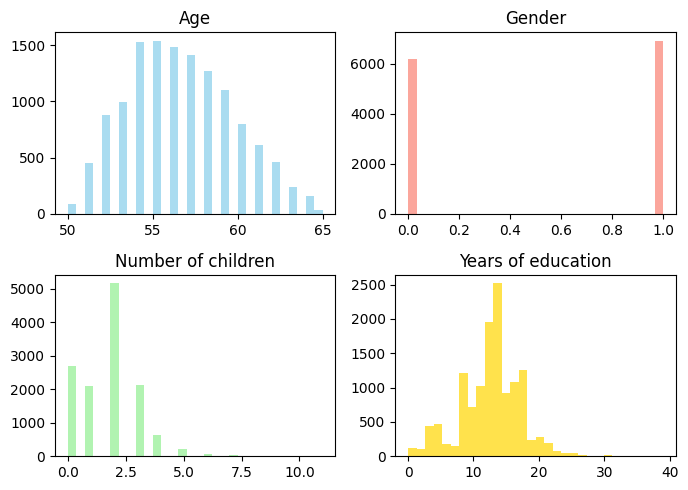

In [64]:
fig, axs = plt.subplots(2, 2, figsize=(7, 5))

axs[0, 0].hist(df["age"], bins=30, color="skyblue", alpha=0.7)
axs[0, 0].set_title("Age")

axs[0, 1].hist(df["gender"], bins=30, color="salmon", alpha=0.7)
axs[0, 1].set_title("Gender")

axs[1, 0].hist(df["nb_children"], bins=30, color="lightgreen", alpha=0.7)
axs[1, 0].set_title("Number of children")

axs[1, 1].hist(df["yrseducation"], bins=30, color="gold", alpha=0.7)
axs[1, 1].set_title("Years of education")

plt.tight_layout()

plt.show()

Job status

In [65]:
round(df["job_status"].value_counts(normalize=True), 2)

job_status
Private sector employee    0.39
Public sector employee     0.22
Employee                   0.20
Self-employed              0.14
Civil servant              0.04
Name: proportion, dtype: float64

Years of contribution, retirement age, work horizon and work horizon change

In [66]:
round(
    df[
        ["yrscontribution", "retirement_age", "work_horizon", "work_horizon_change"]
    ].describe(),
    2,
)

,yrscontribution,retirement_age,work_horizon,work_horizon_change
count,13066.00,13066.00,13066.00,13066.00
mean,35.93,63.13,6.70,0.38
std,6.13,2.11,3.41,0.67
min,5.00,57.00,0.08,0.00
25%,33.00,62.00,4.00,0.00
50%,37.00,63.50,7.00,0.00
75%,40.00,65.00,9.00,0.67
max,55.00,68.00,17.00,4.00


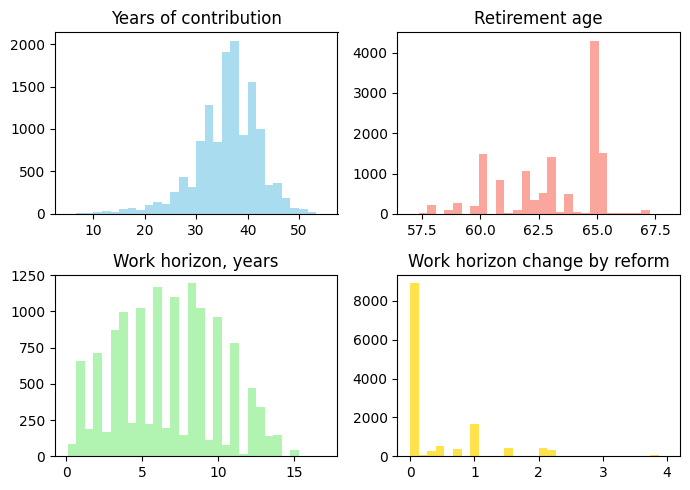

In [67]:
fig, axs = plt.subplots(2, 2, figsize=(7, 5))

axs[0, 0].hist(df["yrscontribution"], bins=30, color="skyblue", alpha=0.7)
axs[0, 0].set_title("Years of contribution")

axs[0, 1].hist(df["retirement_age"], bins=30, color="salmon", alpha=0.7)
axs[0, 1].set_title("Retirement age")

axs[1, 0].hist(df["work_horizon"], bins=30, color="lightgreen", alpha=0.7)
axs[1, 0].set_title("Work horizon, years")

axs[1, 1].hist(df["work_horizon_change"], bins=30, color="gold", alpha=0.7)
axs[1, 1].set_title("Work horizon change by reform")

plt.tight_layout()

plt.show()

EuroD scale (mental health)

In [68]:
round(df["eurodcat"].value_counts(normalize=True), 2)

eurodcat
0    0.81
1    0.19
Name: proportion, dtype: float64

In [69]:
df["eurod"].value_counts()

eurod
0.0     3450
1.0     3194
2.0     2354
3.0     1618
4.0     1117
5.0      648
6.0      357
7.0      186
8.0       74
9.0       48
10.0      14
11.0       5
12.0       1
Name: count, dtype: int64

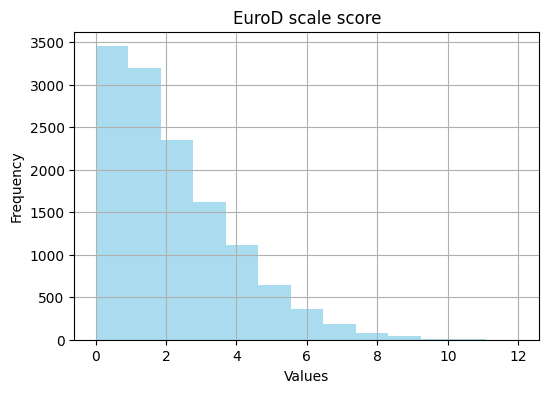

In [70]:
plt.figure(figsize=(6, 4))
plt.hist(df["eurod"], bins=13, color="skyblue", alpha=0.7)
plt.title("EuroD scale score")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [71]:
df.to_csv(
    "/Users/alexandralugova/Documents/GitHub/MH-old-workers/data/datasets/data_clean_w456.csv",
    index=False,
)